# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [28]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import PIL
import cv2
import os
import glob
import re

import torch
from torchvision import datasets, models, transforms

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision.utils import make_grid
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [29]:
ROOT_DIR = 'landmark_images'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')

In [30]:
def print_data(data):
    """
    Parameters
    ----------
    data : dict
    """
    for k, v in data.items():
        print("%s:\t%s" % (k, v))
    print("Min width: %i" % data['min_width'])
    print("Max width: %i" % data['max_width'])
    print("Min height: %i" % data['min_height'])
    print("Max height: %i" % data['max_height'])

In [31]:
files = glob.glob(TRAIN_DIR + '/**/*.jpg', recursive=True)


data = {}
data['images_count'] = len(files)
data['min_width'] = 10**100  # No image will be bigger than that
data['max_width'] = 0
data['min_height'] = 10**100  # No image will be bigger than that
data['max_height'] = 0
df = pd.DataFrame(columns = ['index','min_width','max_width','min_height','max_height'])
i=1
for filename in files:
    im = PIL.Image.open(filename)
    width, height = im.size
    data['min_width'] = min(width, data['min_width'])
    data['max_width'] = max(width, data['max_width'])
    data['min_height'] = min(height, data['min_height'])
    data['max_height'] = max(height, data['max_height'])
    df.loc[i] = [i, min(width, data['min_width']),max(width, data['max_width']), min(height, data['min_height']), max(height, data['max_height'])] 
    i+=1
    
print_data(data)

images_count:	4996
min_width:	225
max_width:	800
min_height:	60
max_height:	800
Min width: 225
Max width: 800
Min height: 60
Max height: 800


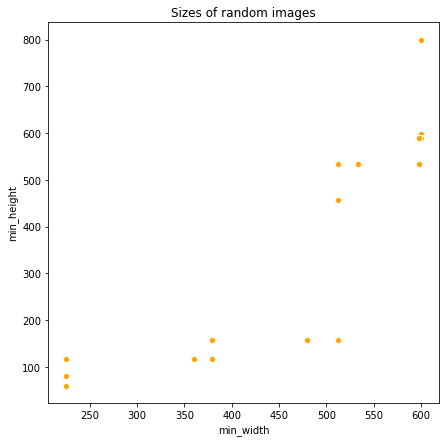

In [32]:
plt.figure(figsize=(7,7))
sns.scatterplot(x='min_width', y='min_height', data=df, color='orange')
plt.title("Sizes of random images")
plt.show()

In [33]:
IMG_SIZE = 128
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.ToTensor()])
train_set = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_set = datasets.ImageFolder(TEST_DIR, transform=transform)

In [34]:
num_workers = 0
batch_size = 20

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers,shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers,shuffle=True)

In [35]:
def get_classname_from_label(label):

    directory_list = list()
    for root, dirs, files in os.walk(TRAIN_DIR, topdown=False):
        for name in dirs:
            directory_list.append(os.path.join(root, name))

    
    keyword = label.item()
    if keyword<10:
        keyword = '0' + str(keyword) 
    else:
        keyword = str(keyword)
    keyword = keyword + "."

    dirn = [dirname for dirname in directory_list if re.search(keyword, dirname)][0]

    return dirn[dirn.find(keyword)+3:]

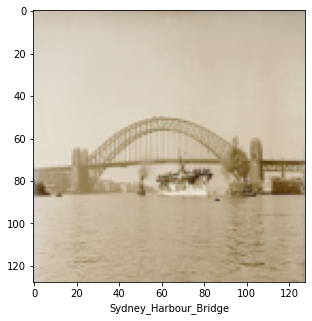

In [36]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])
img = np.transpose(img, (1, 2, 0))
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.set_xlabel(get_classname_from_label(labels[0]))
ax.imshow(img, cmap='gray')

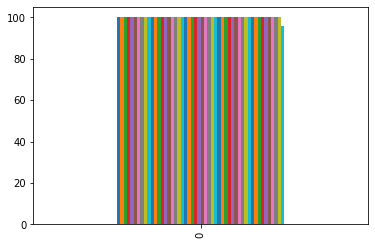

In [37]:
from collections import Counter
d = Counter(train_set.targets)
key = d.keys()

df = pd.DataFrame(d,index=key)
df.drop(df.columns[1:], inplace=True)
df.plot(kind='bar', legend=False)

In [38]:
transform_dict = {
        'train': transforms.Compose(
            [transforms.Resize((IMG_SIZE, IMG_SIZE)),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             ]),
        'valid': transforms.Compose(
            [transforms.Resize((IMG_SIZE, IMG_SIZE)),
             transforms.ToTensor(),
             ]),
        'test': transforms.Compose(
            [transforms.Resize((IMG_SIZE, IMG_SIZE)),
             transforms.ToTensor(),
             ])}

In [39]:
train_set = datasets.ImageFolder(TRAIN_DIR, transform=transform_dict['train'])
test_set = datasets.ImageFolder(TEST_DIR, transform=transform_dict['test'])
valid_size = 0.2
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [40]:
num_workers = 0
batch_size = 20
train_loader = DataLoader(train_set, batch_size=batch_size, sampler = train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_set, batch_size=batch_size, sampler = valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers,shuffle=True)
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [41]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

The code resizes the images to a (128, 128) image size. As seen in the previous cells, this seems to be a good size that covers most of the photos, as there are very few images with sizes smaller than that. Another reason to reduce the image size is the number of parameters: for an image size of 128x128x3 we will have 49,152 parameters. If we would go for the bigger image sizes like 800x800 this will increase the number of parameters to 720,000.

Some minor image augmentation is only applied since the picture are not all normalized, in some cases the landmark is not properly centered so the idea is to compensate for that using random horizontal flips.



### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

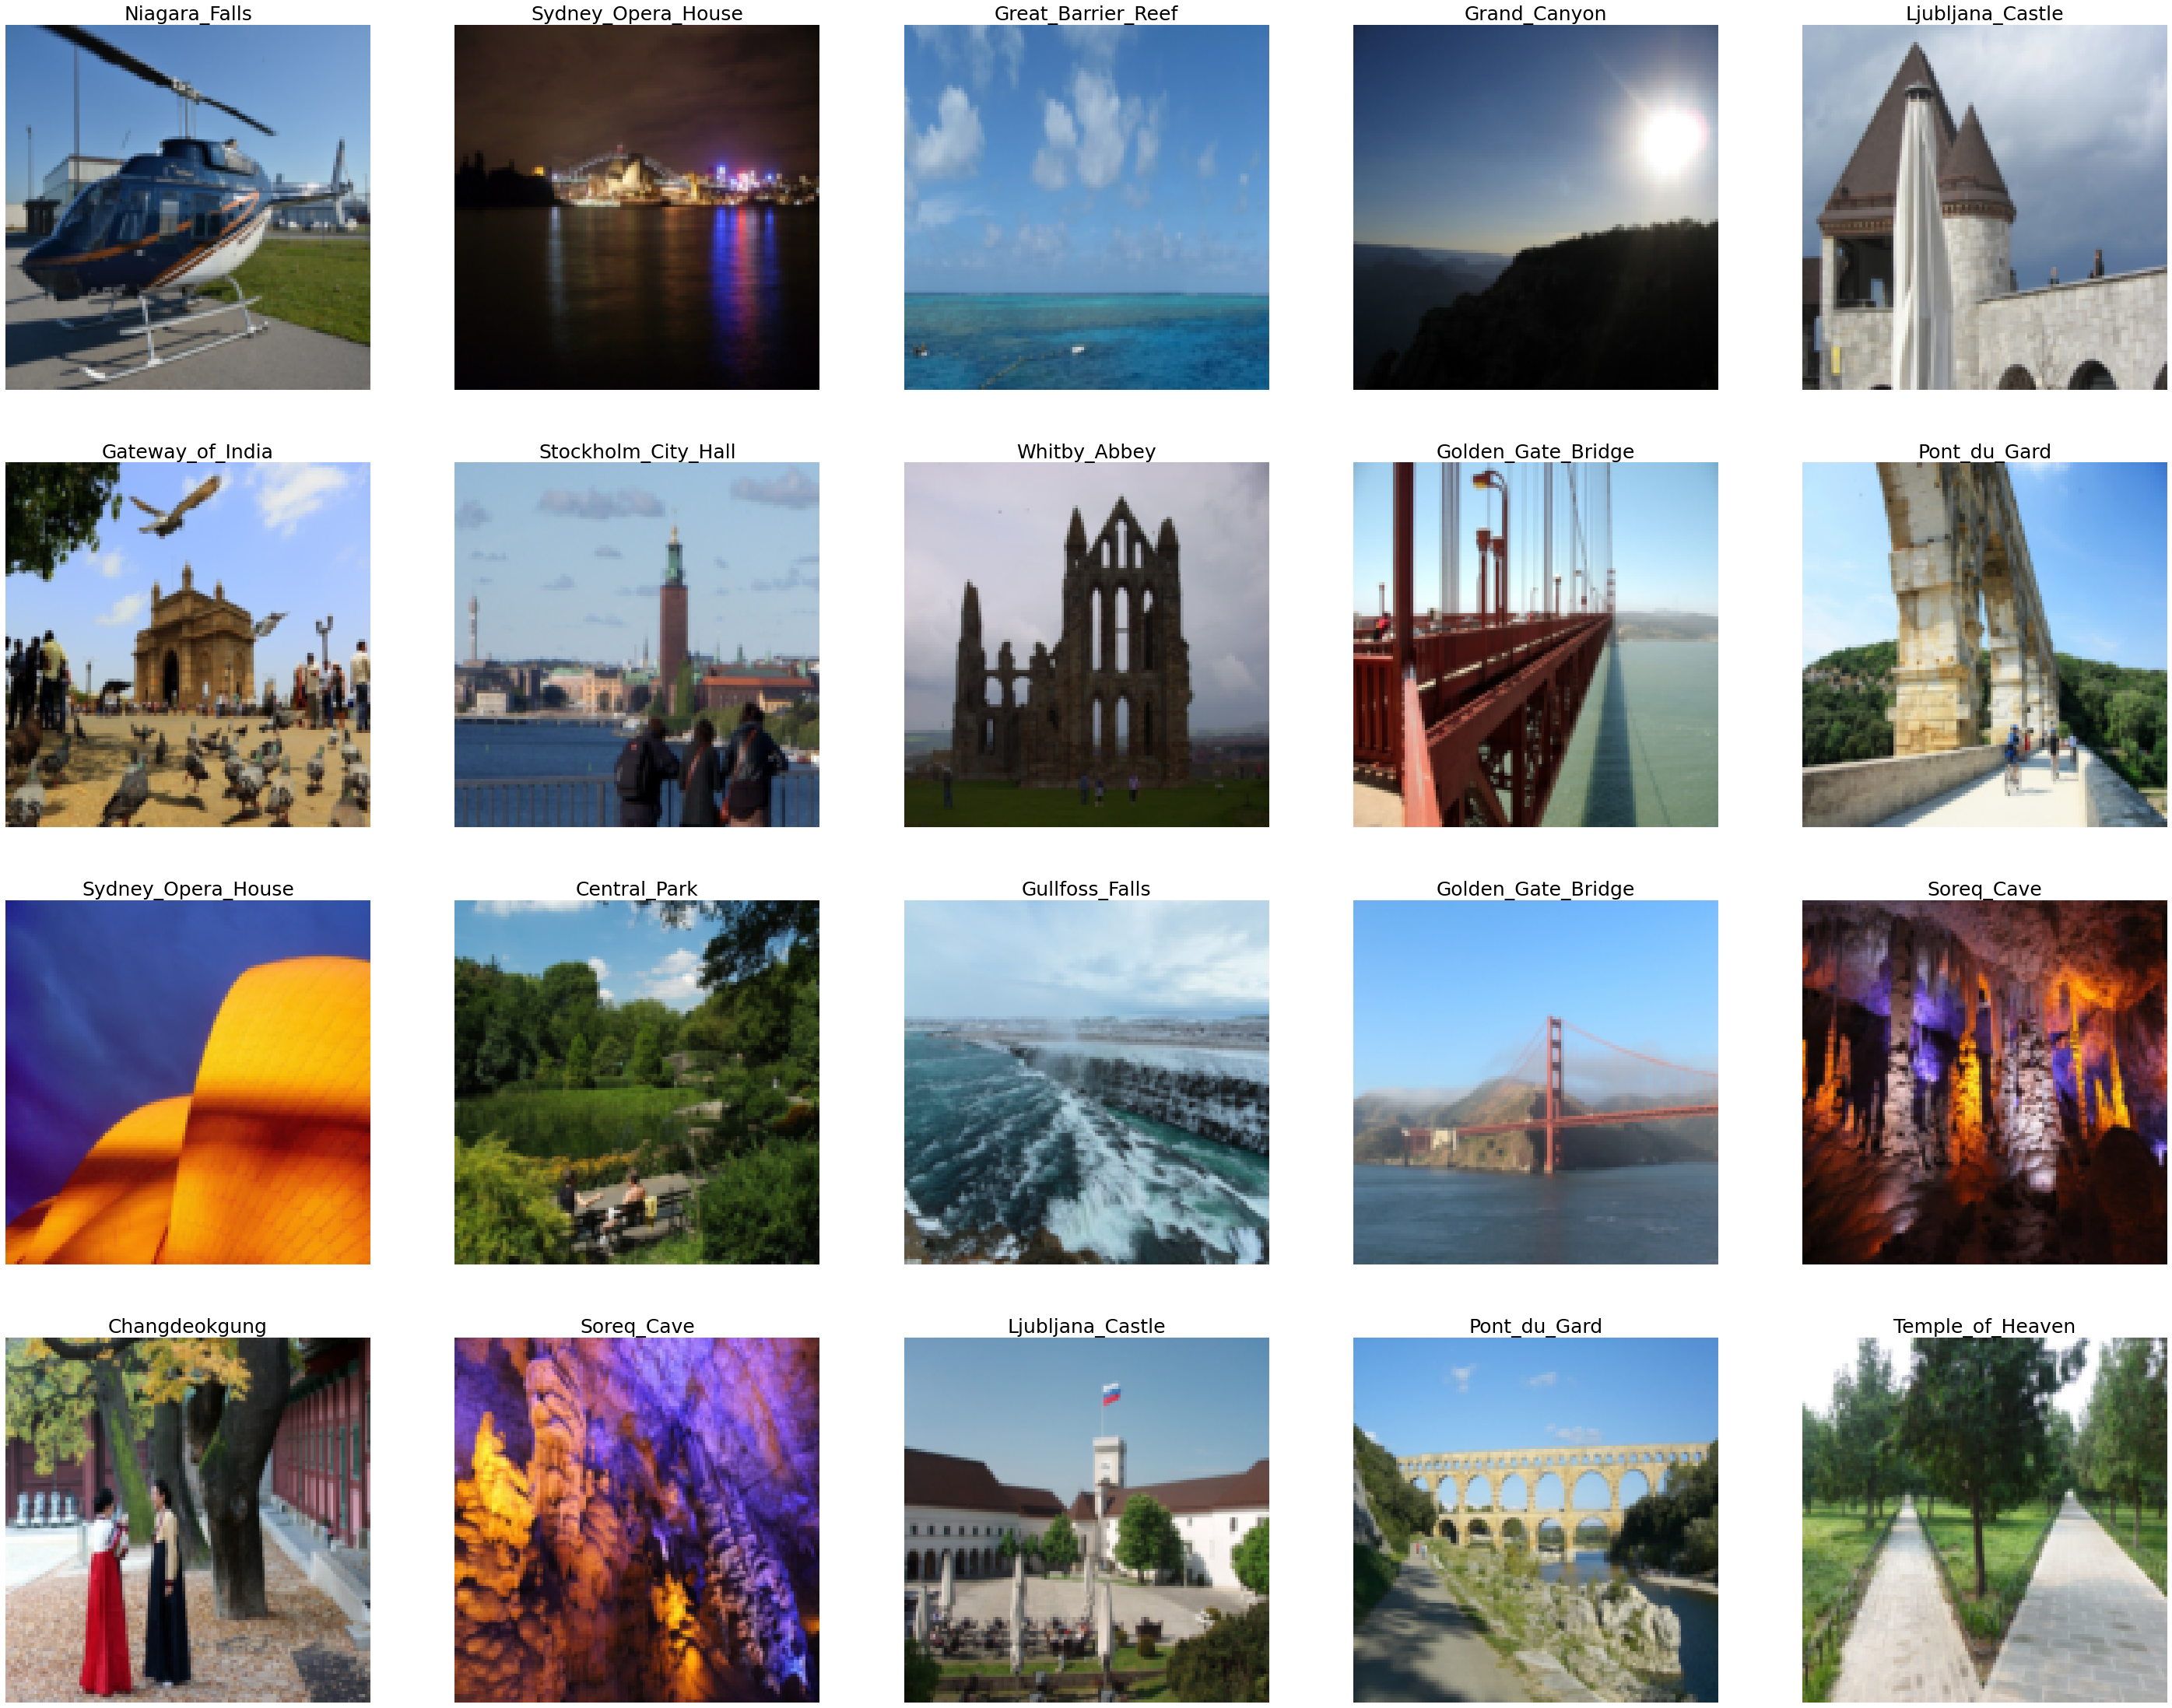

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

count_stop = 20
plt.figure(figsize=(50,50))
for i, batch in enumerate(train_loader, start=1):
    image, label = batch
    img = np.squeeze(image[0])
    img = np.transpose(img, (1, 2, 0))

    plt.subplot(5,5,i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(get_classname_from_label(label[0]), fontsize=25)

    if (i >= count_stop): break
plt.show()



### Initialize use_cuda variable

In [43]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [44]:
## TODO: select loss function
criterion_scratch = CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return  Adam(model.parameters(), lr=0.0001)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [51]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self, constant_weight=None):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 50)
        self.dropout = nn.Dropout(0.25)
        if(constant_weight is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)

        
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

1. The model is a 4 layered convolutional neural network: convolutional layers help to extract complex patternr, and shapes in images. 
2. After every convolutional layer there is a max pooling followed by ReLU activation function. Maxpooling helps reduce feature vector length progressively. 
3. Dropout is used to avoid over-fitting.
4. At the end of the network the feature vector(feature maps) are made into a one-dimensional array.
5. And this array is passed through four fully-connected layers, finally obtaining an output prediction.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [52]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct = 0.0
        total = 0.0 
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))


            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 

            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            pred = output.data.max(1, keepdim=True)[1]
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)     
            

            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        print('Validation Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))
        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss 

        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [53]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 565.662543 	Validation Loss: 0.231271
Validation Accuracy:  2% (21/999)
Validation loss decreased (inf --> 0.231271).  Saving model ...
Epoch: 2 	Training Loss: 0.026512 	Validation Loss: 0.010066
Validation Accuracy:  2% (21/999)
Validation loss decreased (0.231271 --> 0.010066).  Saving model ...
Epoch: 3 	Training Loss: 0.003275 	Validation Loss: 0.006248
Validation Accuracy:  2% (21/999)
Validation loss decreased (0.010066 --> 0.006248).  Saving model ...
Epoch: 4 	Training Loss: 0.001572 	Validation Loss: 0.003917
Validation Accuracy:  2% (21/999)
Validation loss decreased (0.006248 --> 0.003917).  Saving model ...
Epoch: 5 	Training Loss: 0.001253 	Validation Loss: 0.003949
Validation Accuracy:  2% (21/999)
Epoch: 6 	Training Loss: 0.001051 	Validation Loss: 0.003917
Validation Accuracy:  2% (21/999)
Epoch: 7 	Training Loss: 0.000984 	Validation Loss: 0.003917
Validation Accuracy:  1% (15/999)
Epoch: 8 	Training Loss: 0.000988 	Validation Loss: 0.003917
V

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [78]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 5

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')


Epoch: 1 	Training Loss: 0.000978 	Validation Loss: 0.003880
Validation Accuracy:  3% (32/999)
Validation loss decreased (inf --> 0.003880).  Saving model ...
Epoch: 2 	Training Loss: 0.000962 	Validation Loss: 0.003773
Validation Accuracy:  7% (71/999)
Validation loss decreased (0.003880 --> 0.003773).  Saving model ...
Epoch: 3 	Training Loss: 0.000948 	Validation Loss: 0.003732
Validation Accuracy:  8% (81/999)
Validation loss decreased (0.003773 --> 0.003732).  Saving model ...
Epoch: 4 	Training Loss: 0.000935 	Validation Loss: 0.003652
Validation Accuracy:  8% (84/999)
Validation loss decreased (0.003732 --> 0.003652).  Saving model ...
Epoch: 5 	Training Loss: 0.000924 	Validation Loss: 0.003640
Validation Accuracy: 10% (103/999)
Validation loss decreased (0.003652 --> 0.003640).  Saving model ...


### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [55]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.852861


Test Accuracy: 30% (379/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [56]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

IMG_SIZE = 224

transform_dict = {
        'train': transforms.Compose(
            [transforms.Resize((IMG_SIZE, IMG_SIZE)),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             ]),
        'valid': transforms.Compose(
            [transforms.Resize((IMG_SIZE, IMG_SIZE)),
             transforms.ToTensor(),
             ]),
        'test': transforms.Compose(
            [transforms.Resize((IMG_SIZE, IMG_SIZE)),
             transforms.ToTensor(),
             ])}

train_set = datasets.ImageFolder(TRAIN_DIR, transform=transform_dict['train'])
test_set = datasets.ImageFolder(TEST_DIR, transform=transform_dict['test'])
valid_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

num_workers = 0
batch_size = 20

train_loader = DataLoader(train_set, batch_size=batch_size, sampler = train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_set, batch_size=batch_size, sampler = valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers,shuffle=True)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [57]:
## TODO: select loss function
criterion_transfer = CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return  Adam(model.parameters(), lr=0.0001)
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [80]:
## TODO: Specify model architecture

model_transfer = models.vgg16(pretrained=True)
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 50)
model_transfer.classifier[6] = last_layer

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

I have chosen the VGG16 architecture that was trained on Imagenet datasetas these weights can successfully capture the generic features from landmarks.

All the convolutional layers are maintained the same
The last layer is replaced with a fully connected layer which acts as  our own classifier.
VGGNet is used as fixed feature extractor for our images then easily train a simple classifier on top of that. 

A simple model can be progressively improved over time whereas this isn't possible with a complex model, the model leads to improved computational efficiency.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [59]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

optimizer = get_optimizer_transfer(model_transfer)
# number of epochs to train the model
n_epochs = 10

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf 
    
for epoch in range(1, n_epochs+1):
    # initialize variables to monitor training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    # intialize variables to calculate validation accuracy per epoch
    correct = 0.0
    total = 0.0         
    ###################
    # train the model #
    ###################
    # set the module to training mode
    model_transfer.train()
    for batch_idx, (data, target) in enumerate(loaders_transfer['train']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        ## find the loss and update the model parameters accordingly
        ## record the average training loss, using something like
        ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion_transfer(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))          

    ######################    
    # validate the model #
    ######################
    # set the model to evaluation mode
    model_transfer.eval()
    for batch_idx, (data, target) in enumerate(loaders_transfer['valid']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        ## update average validation loss 

        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion_transfer(output, target)
        # update average validation loss 
#             valid_loss += loss.item()*data.size(0)
        valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)     
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

    print('Validation Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
        
    ## if the validation loss has decreased, save the model at the filepath stored in save_path
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model_transfer.state_dict(), 'model_transfer.pt')
        valid_loss_min = valid_loss  
        

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.000903 	Validation Loss: 0.002432
Validation Accuracy: 40% (406/999)
Validation loss decreased (inf --> 0.002432).  Saving model ...
Epoch: 2 	Training Loss: 0.000515 	Validation Loss: 0.001804
Validation Accuracy: 54% (545/999)
Validation loss decreased (0.002432 --> 0.001804).  Saving model ...
Epoch: 3 	Training Loss: 0.000331 	Validation Loss: 0.001430
Validation Accuracy: 62% (620/999)
Validation loss decreased (0.001804 --> 0.001430).  Saving model ...
Epoch: 4 	Training Loss: 0.000228 	Validation Loss: 0.001333
Validation Accuracy: 64% (649/999)
Validation loss decreased (0.001430 --> 0.001333).  Saving model ...
Epoch: 5 	Training Loss: 0.000153 	Validation Loss: 0.001422
Validation Accuracy: 67% (671/999)
Epoch: 6 	Training Loss: 0.000117 	Validation Loss: 0.001550
Validation Accuracy: 65% (657/999)
Epoch: 7 	Training Loss: 0.000082 	Validation Loss: 0.001437
Validation Accuracy: 68% (685/999)
Epoch: 8 	Training Loss: 0.000077 	Validation Loss: 0.001

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [60]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.151613


Test Accuracy: 70% (878/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [61]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    pil_image = Image.open(image_path)
    if pil_image.size[1] < pil_image.size[0]:
        pil_image.thumbnail((255, math.pow(255, 2)))
    else:
        pil_image.thumbnail((math.pow(255, 2), 255))
    left = (pil_image.width-224)/2
    bottom = (pil_image.height-224)/2
    right = left + 224
    top = bottom + 224
                            
    pil_image = pil_image.crop((left, bottom, right, top))
                            
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])  
    np_image = (np_image - mean)/std
    np_image = np.transpose(np_image, (2, 0, 1))
    
    return np_image

In [62]:
def get_classname_from_id(keyword):

    directory_list = list()
    for root, dirs, files in os.walk(TRAIN_DIR, topdown=False):
        for name in dirs:
            directory_list.append(os.path.join(root, name))


    if keyword<10:
        keyword = '0' + str(keyword) 
    else:
        keyword = str(keyword)
    keyword = keyword + "."

    dirn = [dirname for dirname in directory_list if re.search(keyword, dirname)][0]

    return dirn[dirn.find(keyword)+3:]

In [64]:
import cv2
from PIL import Image
import math

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    if k < 1:
        k = 1
        
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))
    model_transfer.eval()
    with torch.no_grad():
        img = process_image(img_path)
        img = torch.from_numpy(img).unsqueeze(0)
        img = img.float()
        logps = model_transfer.forward(img)
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(k, dim=1)
        return top_p, top_class


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

(tensor([[591.4767, 522.0059,  22.3178,  17.6683,   1.3698]]),
 tensor([[ 9, 38, 30, 28, 36]]))

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [72]:
def suggest_locations(img_path):
    # get landmark predictions
    #predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = process_image(img_path)
  
    probs, classes = predict_landmarks('{}'.format(img_path), 3)

    print()
    print('The model predicts this landmark as: ')
    print()
    for count in range(3):
        classes_array = classes[0, count].numpy()
        print('{} ...........{:.10f} %'.format(get_classname_from_id(classes_array), probs[0, count]/10))
    
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')


The model predicts this landmark as: 

Golden_Gate_Bridge ...........59.1476669312 %
Forth_Bridge ...........52.2005920410 %
Brooklyn_Bridge ...........2.2317779064 %


### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The output is better than expected on the transfer learning based model. 
1. Better data augmentation phase, may impact potential feature detection, so adding random basic image augmentation techniques like normalization, rotation, scaling etc. and this may result in better performance.

2. There can be more fully connected layers added at the end of the models , and this might help the model to make more accurate predictions.

3. Training the model for longer, more number of epochs. 

In [77]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

suggest_locations('landmark_images/1.jpg')
suggest_locations('landmark_images/2.jpg')
suggest_locations('landmark_images/3.jpg')
suggest_locations('landmark_images/4.jpg')

The model predicts this landmark as:
Mount_Rainier_National_Park ...........55.1163806915 %
Grand_Canyon ...........12.514609098 %
Central_Park ...........6.475740671 %

The model predicts this landmark as: 

Grand_Canyon ...........23.73596191406 %
Soreq_Cave ...........5.616746545 %
Central_Park ...........4.641331732 %

The model predicts this landmark as: 

Badlands_National_Park ...........11.401361227 %
Machu_Picchu ...........9.338971972 %
Death_Valley_National_Park ...........8.363400698 %

The model predicts this landmark as: 

Niagara_Falls ...........44.4062500000 %
Brooklyn_Bridge ...........21.1178169250 %
Dead_Sea ...........10.9931793213 %
